In [1]:
import cvxpy as cp
import numpy as np
import seaborn as sns
import scipy
import time
from tqdm import tqdm

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

# CVXPY

https://www.cvxpy.org/


[официальный миникурс по cvxpy](https://www.cvxgrp.org/cvx_short_course/docs/index.html), 
https://www.youtube.com/watch?v=GfLyfLKoMIU - Бойд объясняет, как работает cvxpy

- Опенсорсный "modeling language" для выпуклых задач оптимизации на Python

- Работает в парадигме задач оптимизации с известной структурой (не чёрный ящик)

- Для задач не очень большой размерности ($10^3-10^4$ переменных) в среднем должен работать в 2-10 раз медленнее чем солвер, специально заточенный под задачу, но в 10+ раз быстрее программироваться

- Не решает задачу сам, но позволяет записать её в удобном виде на Python, а потом компилирует и передаёт в солвер

- Дополнительно к выпуклым поддерживает смешанные целочисленно-выпуклые задачи, квазивыпуклые задачи и геометрическое программирование



Пример использования: решение СЛАУ с наименьшей 1-нормой
$\newcommand{\R}{\mathbb R}$$$\begin{align}
&\min_{x\in \R^d} \|x\|_1 \\
\text{s.t. }& Ax = b \\
\end{align}$$


In [2]:
m, n = 15, 20
A, b = np.random.randn(m, n), np.random.randn(m)

x = cp.Variable(n)
f = cp.norm1(x)  # указываем целевую функцию
constraints = [A @ x == b]  # указываем ограничения
prob = cp.Problem(cp.Minimize(f), constraints)
prob.solve()

print("Оптимальное значение целевой функции:", prob.value)
print("Норма невязки ограничений:", np.linalg.norm(A @ x.value - b))
print("Решения прямой и двойственной задач:") 
_ = print(x.value), print(constraints[0].dual_value)

Оптимальное значение целевой функции: 6.669125017504214
Норма невязки ограничений: 8.864021445561153e-13
Решения прямой и двойственной задач:
[-7.59150313e-02 -9.66624939e-02  1.73400576e-01 -6.03628397e-01
  1.58950812e+00 -6.76315183e-02 -1.20733426e-01 -5.05961381e-01
  5.50411054e-01  5.00536121e-01  6.33424300e-10 -2.77311790e-01
  2.07466365e-01 -1.07794199e+00 -7.30751159e-09 -3.86613503e-09
  7.23673528e-01 -1.52109580e-09 -1.01410500e-09  9.83432163e-02]
[ 0.01398841  0.95385703 -0.08832165  0.44859004 -1.57382078 -0.55145182
 -0.62317134  0.47689223 -0.40588397  0.21038538 -0.7121551  -0.85146179
  1.22770178  0.35037949  0.36570223]


C:\Users\Georgy\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Получили решение прямой и двойственной задач без
- Реализации функций, вычисляющих (суб)градиент / гессиан
- Построения двойственной задачи и выписывания сопряженных функций
- Выбора алгоритма оптимизации

Далее разберёмся, как это работает и как этим пользоваться

## Disciplined Convex Programming (DCP)
https://dcp.stanford.edu/

- DCP - (теоретический) фреймворк для описания выпуклых задач минимизации, основа CVXPY
- Задачи, записанные в DCP, можно эффективно равносильными преобразованиями привести к стандартному (коническому: LP, SDP, ...) виду и передать в солвер. CVXPY делает это автоматически
- Использует достаточные, но не необходимые условия выпуклости $\Rightarrow$ иногда нужно предварительно руками (и головой) привести задачу в DCP-форму перед записью в CVXPY (CVXPY требует, чтобы выпуклые задачи удовлетворяли правилам DCP)
<!-- Коническая задача - стандартная промежуточная форма для записи задач оптимизации -->

### Общее правило выпуклой композиции
- $h(f_1(x), . . . , f_n (x))$ - выпуклая функция, если $h$ - выпуклая (в совокупности) функция, и для каждого индекса $i$
    - либо $h$ - возрастающая функция $i$-го аргумента и $f_i$ выпуклая
    - либо $h$ - убывающая функция $i$-го аргумента и $f_i$ вогнутая
    - либо $f_i$ аффинная ($f_i(x) = a^\top x + b$)

- Для вогнутой комбинации работает то же самое правило, нужно только заменить "выпуклая" на "вогнутая" в тексте выше. 

**Доказательство**
$\newcommand{\uo}[3]{\underset{#1}{\overset{#2}{#3}}}$
Для определенности предположим, что $f_i - выпуклые$

$\newcommand{\vf}{\vec f}$ 
$$\vf(\alpha x_1 + (1-\alpha) x_2) \stackrel{выпуклость ~f_i}\leq \alpha \vf(x_1) + (1-\alpha) \vf(x_2),$$ где неравенство понимается покомпонентно. Поэтому

$$h(\vf(\alpha x_1 + (1-\alpha) x_2)) \stackrel{монотонность~h}{\leq} h(\alpha \vf(x_1) + (1-\alpha) \vf(x_2))
\stackrel{выпуклость~h}{\leq} \alpha h(\vf(x_1)) + (1-\alpha) h(\vf(x_2))$$

Случай, когда $f_i$ вогнутая, а $h$ убывает по $i$-му аргументу аналогичен рассмотренному выше. В случае, когда $f_i$-аффинные, первые два неравенства заменяются на равенства



Это единственное правило, которое нужно знать, чтобы использовать CVXPY. Остальные операции, сохраняющие выпуклость, следуют из него. Например:
- Сумма выпуклых функций выпукла, т.к. $f_1(x) + f_2(x) = \text{sum}(f_1(x), f_2(x))$, $h = \text{sum}$ - выпуклая, возрастающая функция своих аргументов
- Поточечный максимум: $\max \{f_1(x), f_2(x), \ldots, f_n(x)\}$ - аналогично

### Что это даёт?
Небольшой набор **(~20) функций** с известными свойствами (выпуклость, монотонность) **+ правило выпуклой композиции** позволяет записать и доказать выпуклость **огромного количества задач**.

Технически, нужно ещё отслеживать знакоопределённость значений функций, так как монотонность может зависеть от знака аргумента: например, $\|x\|_1, \|x\|_2$ возрастают по $x_i$ при $x_i \geq 0$ и убывают при $x_i \leq 0$.  

### Пример анализа функции по DCP

$$\frac{(x-y)^2}{1-\max(x,y)}, \quad x < 1,~y<1$$
Эта функция выпукла на заданном множестве:
- (листья) $x$, $y$, $1$ - аффинные функции
- $\max(x, y)$ - выпуклая функция, $x-y$ - аффинная
- $u^2/v$ - выпуклая функция, монотонно убывающая по $v$ при $v > 0$, поэтому выпукла для $u = (x-y)^2$, $v = 1 - \max(x, y)$

Разбор этой функции на сайте https://dcp.stanford.edu/analyzer
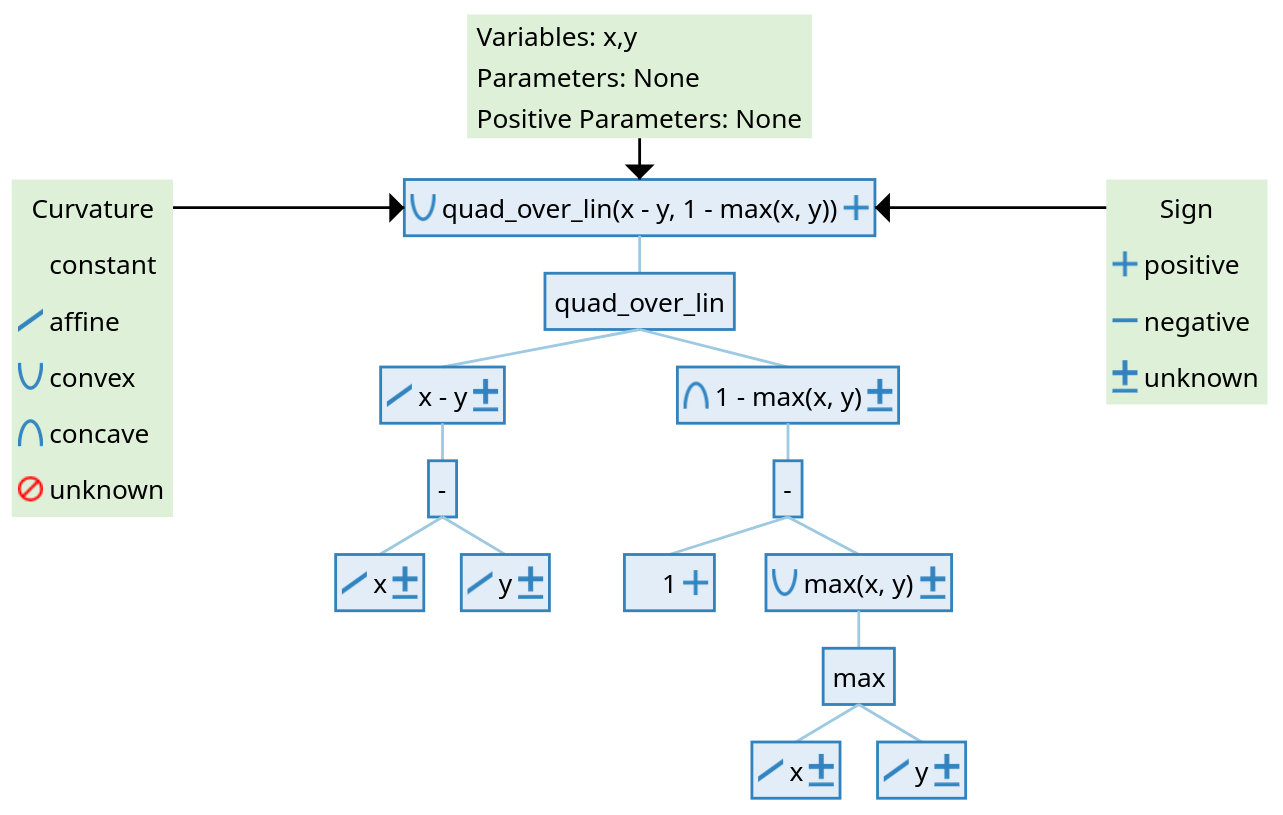

### Формальное определение задачи в форме DCP 
Задача удовлетворяет правилам DCP, если она
- имеет не более одной **цели (objective)** вида
    - `minimize {скалярное выпуклое выражение}` или
    - `maximize {скалярное вогнутое выражение}`
    
и 
- имеет 0 или более **ограничений** вида
    - `{выпуклое выражение} <= {вогнутое выражение}` или
    - `{вогнутое выражение} >= {выпуклое выражение}` или
    - `{аффинное выражение} == {аффинное выражение}`
   
и выпуклость/вогнутость/аффинность может быть установлена по общему правилу выпуклой композиции
    


### Задачи на приведение к DCP-форме

Не всегда выражение, соответствующее выпуклой функции, удовлетворяет правилам DCP. Например, $x^2 - \frac12 x^2$ не проходит, потому что нет правила для разности выпуклых функций.

**Пример 1.** $f(x) = \sqrt{1+x^2}$ - выпуклая функция.

Забегая вперёд, попробуем минимизировать её в CVXPY

In [3]:
x = cp.Variable()
f = (x**2 + 1) ** 0.5
cp.Problem(cp.Minimize(f)).solve()  # DCPError: Problem does not follow DCP rules. The objective is not DCP

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
power(power(var34, 2.0) + 1.0, 0.5)
However, the problem does follow DQCP rules. Consider calling solve() with `qcp=True`.

Квадратный корень - вогнутая возрастающая функция, $1 + x^2$ - выпуклая функция. Применить общее правило выпуклой композиции не получается, поэтому $f(x)$ не удовлетворяет правилам DCP.

Но можно записать эту функцию в другом виде: $f(x) = \left\|\begin{pmatrix}1\\x\end{pmatrix}\right\|_2$. 
Норма - выпуклая функция, $\begin{pmatrix}1\\x\end{pmatrix}$ - аффинная функция от $x$. По правилу выпуклой композиции $f(x)$ - выпукла

In [4]:
x = cp.Variable()
f = cp.norm(cp.hstack((1, x)))
cp.Problem(cp.Minimize(f)).solve()  # ok

1.0

**Пример 2.**

$\newcommand{\R}{\mathbb R}$$$\begin{align}
&\min_{x\in \R} x + 2 \\
\text{s.t. }& 5 = 2/x \\
& x > 0
\end{align}$$


Задача не удовлетворяет правилам DCP, потому что в ограничение вида равенства входит функция, не являющаяся аффинной 

In [5]:
x = cp.Variable()
prob = cp.Problem(cp.Minimize(x + 2), [5 == 2 * cp.inv_pos(x)])
prob.solve()  # DCPError: Problem does not follow DCP rules. Constraints are not DCP

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
2.0 @ power(var52, -1.0) == 5.0 , because the following subexpressions are not:
|--  2.0 @ power(var52, -1.0) == 5.0

Сделаем замену $t = 1/x > 0$. Поскольку $x = 1/t$, и эта функция выпуклая при $t > 0$, получим задачу минимизации выпуклой функции с аффинными ограничениями

In [6]:
t = cp.Variable()
prob = cp.Problem(cp.Minimize(cp.inv_pos(t) + 2), [5 == 2 * t])
prob.solve()  # ok

2.399999999999572

**Пример 3.**


$$\begin{align}
&\min_{x \in \R} x + 2 \\
\text{s.t. }& 5 \leq 2/x^2 \\
\end{align}$$


Задача не удовлетворяет правилам DCP, потому что в ограничении выпуклая функция стоит справа от знака $\leq$

In [7]:
x = cp.Variable()
prob = cp.Problem(cp.Minimize(x + 2), [5 <= 2 * x**-2])
prob.solve()  # DCPError: Problem does not follow DCP rules. Constraints are not DCP

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
5.0 <= 2.0 @ power(var89, -2.0) , because the following subexpressions are not:
|--  5.0 <= 2.0 @ power(var89, -2.0)
However, the problem does follow DQCP rules. Consider calling solve() with `qcp=True`.

Умножим обе части неравенства на $x^2$ 

In [8]:
x = cp.Variable()
prob = cp.Problem(cp.Minimize(x + 2), [5 * x**2 <= 2])
prob.solve()  # ok

1.3675444680250728

## Как CVXPY преобразовывает задачи
### Общая схема
- Для каждой функции-атома $f(x)$ из библиотеки ([полный список](https://www.cvxpy.org/api_reference/cvxpy.atoms.html)) известно представление этой функции в виде решения некоторой конической задачи
- CVXPY идёт по дереву арифметического выражения и заменяет функции на их конические представления
- В результате получается задача из стандартного класса конических задач (LP, SDP, ...)
- В зависимости от того, к какому классу преобразовалась исходная задача, подбирается подходящий солвер и производятся финальное преобразование задачи к форме, определяемой API солвера
- DCP гарантирует, что получившаяся задача эквивалентна исходной

### Чуть подробнее
- Для функций-атомов $f(x)$ в библиотеке имеется их коническое представление
$$\begin{align}
&\min_{y} c^\top x + d^\top y + e \\
\text{s.t. }& A\begin{pmatrix}x\\y\end{pmatrix} = b, \quad \begin{pmatrix}x\\y\end{pmatrix} \in K,
\end{align}$$
где $K$ - один из стандартных конусов: $\R^n_+$ (в случае, если сводится к LP), конус второго порядка, экспоненциальный и тд
- Функции в задаче заменятся коническими представлениями
    - Для каждого атома $f(x)$ добавляется переменная $y$
    - Вхождения $f(x)$ в задачу заменяются на $c^\top x + d^\top y + e$
    - К текущему набору ограничений добавляются ограничения из конического представления $f(x)$
- Получается задача с линейным функционалом и коническими и аффинными ограничениями



### Пример

$\newcommand{\R}{\mathbb R}$$$\begin{align}
&\min_{x\in \R^d} \max\{\|x\|_1, \|x\|_2^2 \} \\
\text{s.t. }& Ax = b \\
\end{align}$$

- Конические представления атомов
    - $$\max_{i=1,\ldots,n} x_i = \min\{y ~|~ x_i \leq y,~i=1,\ldots, n,~ y \in \R\}  \quad \text{(LP)}$$
    - $$\|x\|_1 = \sum_{i=1}^d |x_i|, \quad |x_i| = \max\{x_i, -x_i\} \quad \text{(LP)}$$
    - $$\|x\|_2^2 = \min\left\{t~|~ \|(2x, t-1)^\top\|_2 \leq t+1,~ t\geq 0\right\}  \quad \text{(SOCP)}$$
    так как $\|(2x, t-1)^\top\|_2 \leq t+1 \Leftrightarrow \|x\|_2^2 \leq t$
    
- Рекурсивно заменяем атомы на их конические представления
    - Внешний максимум
    $$\max\{\|x\|_1, \|x\|_2^2\} =
    \begin{array}{ll}
     &\min_{p} p
    \\\text{s.t.} &\|x\|_1 \leq p
    \\&\|x\|_2^2 \leq p
    \end{array}$$

    - Квадрат второй нормы
    $$
    \max\{\|x\|_1, \|x\|_2^2\} =
    \begin{array}{ll}
    &\min_{p, t} p 
    \\~~\text{s.t.} &\|x\|_1 \leq p
    \\& t \leq p
    \\&\|(2x, t-1)^\top\|_2 \leq t+1,
    \\& t \geq 0
    \end{array}$$

    - Первую норму
    $$
    \max\{\|x\|_1, \|x\|_2^2\} = 
    \begin{array}{ll}
     &\min_{p, t, y} p &
    \\~~\text{s.t. } &\sum_{i=1}^d y_i \leq p
    \\& x \leq y
    \\& -x \leq y
    \\& t \leq p
    \\&\|(2x, t-1)^\top\|_2 \leq t+1,
    \\& t \geq 0
    \end{array}$$


- Осталось добавить $\min_x$ и исходное аффинное ограничение $Ax=b$ - получим равносильное преобразование задачи в задачу из класса SOCP. Её можно далее привести к стандартному виду, как это делалось на семинаре про классы выпуклых задач


$$\begin{align}
\max\{\|x\|_1, \|x\|_2^2\} =& \min_{p} p \\
\text{s.t. } &\|x\|_1 \leq p \\
&\|x\|_2^2 \leq p
\end{align}$$


- Все эти преобразования CVXPY делает автоматически

In [15]:
m, n = 15, 20
A, b = np.random.randn(m, n), np.random.randn(m)

x = cp.Variable(n)
f = cp.maximum(cp.norm1(x), cp.sum_squares(x))  # указываем целевую функцию
constraints = [A @ x == b]  # указываем ограничения
prob = cp.Problem(cp.Minimize(f), constraints)
prob.get_problem_data(cp.SCS)  # можно посмотреть на результат преобразования
prob.solve()

5.036851108689182

## Резюме
- CVXPY позволяет освободить пользователей от необходимости знания способов преобразования задач к стандартому виду.
После того как редукцию хитрой функции типа $x_{[1]} + \ldots + x_{[r]}$ к задаче LP добавили в CVXPY, пользователям можно больше об этом не думать - редукция применится автоматически
- Вместо знания кучи редукций и ручной работы по их применению пользователю нужно заботиться только о приведении задачи к DCP-виду, которое, по сути, заключается в одном правиле выпуклой композиции

### Интерфейс CVXPY
Рассмотрим задачу
\begin{align}
\min_{x\in \R,y \in \R} ~ & (x-y)^2 \\
 \mbox{s.t. } & x+y=1 \\
& x-y \geq 1 \\
\end{align}





In [10]:
# Создаём скалярные переменные
x = cp.Variable()
y = cp.Variable()

# Ограничения
constraints = [x + y == 1,
               x - y >= 1]

print("Constraints: ", constraints, "\n") # это не bool, это выражения

# Целевая функция
obj = cp.Minimize((x - y)**2)

# Создаём задачу
prob = cp.Problem(obj, constraints)

# Решаем задачу.
# Побочный эффект: обновляются значения переменных, поля prob.status и prob.value, поля объектов ограничений
prob.solve()

print("status:", prob.status)  # “optimal” значит что задача успешно решилась
print("optimal value:", prob.value)  # оптимальное значение целевой функции
print("optimal var (x,y):", x.value, y.value)  # оптимальные значения переменных (решение задачи)

print()

# Решение двойственной задачи (оптимальные значения множителей Лагранжа) лежат в constraint.dual_value.
print("optimal (x + y == 1) dual variable: u =", constraints[0].dual_value) 
print("optimal (x - y >= 1) dual variable: lmb =", constraints[1].dual_value) 



Constraints:  [Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())), Inequality(Constant(CONSTANT, NONNEGATIVE, ()))] 

status: optimal
optimal value: 1.0
optimal var (x,y): 1.0 1.570086213240983e-22

optimal (x + y == 1) dual variable: u = 0.0
optimal (x - y >= 1) dual variable: lmb = 2.0


### Поддерживаемые солверы и классы задач
Напомним, CVXPY не решает задачу сам, а вызывает внешние солверы.

Полная версия таблицы [здесь](https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver)


|                | LP | QP | SOCP | SDP | EXP | POW | MIP |
|----------------|----|----|------|-----|-----|-----|-----|
| CLARABEL    | X  | X  | X    |  X  |  X  |  X  |     |
| GLPK        | X  |    |      |     |     |     |     |
| GLPK_MI     | X  |    |      |     |     |     | X   |
| OSQP        | X  | X  |      |     |     |     |     |
| CPLEX       | X  | X  | X    |     |     |     | X   |
| ECOS        | X  | X  | X    |     | X   |     |     |
| GUROBI      | X  | X  | X    |     |     |     | X   |
| MOSEK       | X  | X  | X    | X   | X   | X   | X** |
| CVXOPT      | X  | X  | X    | X   |     |     |     |
| SCS         | X  | X  | X    | X   | X   | X   |     |
| SCIP        | X  | X  | X    |     |     |     | X   |
| SCIPY       | X  |    |      |     |     |     | X*  |


Вы можете изменить **солвер**, вызываемый CVXPY, используя параметр `solver` метода `problem.solve`.

По умолчанию CVXPY вызывает солвер, наиболее специализированный для данного типа задачи. Например, для SOCP вызывается ``ECOS``. SCS может решать все задачи (кроме смешанных целочисленных программ). Для QP CVXPY использует OSQP.

CVXPY опирается на опенсорсные солверы ECOS, CVXOPT и SCS. Дополнительные солверы поддерживаются, но должны устанавливаться отдельно.

Основные солверы с открытым исходным кодом: ``ECOS``, ``OSQP``, ``SCS``.

Коммерческие солверы: ``CPLEX``, ``GUROBI``, ``XPRESS``,  ``MOSEK``. 

У разных солверов параметры (например, максимальное число итераций) называются по-разному. См [список параметров](https://www.cvxpy.org/tutorial/advanced/index.html#setting-solver-options)





### Несовместные и неограниченные задачи
Если в процессе `problem.solve()` выяснится, что задача несовместна (нет допустимых точек, ограчниения задают пустое множество) или неограниченна (значение целевой функции может стремиться к $-\infty$ для задачи минимизации), в поле `problem.status` выставятся значения `'infeasible'` или `'unbounded'` соответственно.

Пример несовместной задачи 
\begin{align}
\min ~ & x\\
 \mbox{s.t. } & x\geq 1 \\
 & x\leq -1 \\
\end{align}

Пример неограниченной задачи
\begin{align}
\min ~ & x\\
\end{align}

In [16]:
print("Несовместная задача \n")
x = cp.Variable()
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= -1]) 
result = prob.solve()
print("Оптимальное значение функции:", result)
print("Решение:", x.value)
print("Статус:", prob.status, "\n\n")

print("Неограниченная задача \n")
prob = cp.Problem(cp.Minimize(x)) 
result = prob.solve()

print("Оптимальное значение функции:", result)
print("Решение:", x.value)
print("Статус:", prob.status)

Несовместная задача 

Оптимальное значение функции: inf
Решение: None
Статус: infeasible 


Неограниченная задача 

Оптимальное значение функции: -inf
Решение: None
Статус: unbounded


### Переменные
Могут быть скалярными, векторными или матричными. Более высокие размерности пока не поддерживаются, их нужно обрабатывать вручную

In [12]:
# Скалярная переменная
a = cp.Variable()

# Векторная переменная размерности 5
x = cp.Variable(5)

# Матричная переменная размерности 5 x 1.
X = cp.Variable((5, 1))


### Параметры
Параметры можно использовать вместо констант, если планируется решать задачу несколько раз при разных значениях параметров. При этом задача не будет перекомпилироваться. Также можно вычислять производные решения по значениям параметров.

In [13]:
# Неотрициательный скалярный параметр
m = cp.Parameter(nonneg=True)

# Векторный параметр неопределённого знака (по умолчанию).
c = cp.Parameter(5)

# Матричный параметр с неположительными элементами
G = cp.Parameter((4, 7), nonpos=True)

# Присвоение значения параметру
G.value = -np.ones((4, 7))

### Ограничения

Определяются с помощью операторов `==`, `<=`, и `>=`. 
Можно (и нужно) использовать неравенства между векторами и матрицами, они будут пониматься покомпонентно

Нельзя использовать строгие неравенства `<` и `>`- на практике в них мало смысла.

Сравнения по цепочке (`a <= b <= c`, `a == b == c`) тоже не поддерживаются

### Целочисленные переменные

Чтобы решать задачи с дискретными переменными, достаточно выставить флаги `boolean` или `integer` при создании переменных

In [14]:
x = cp.Variable(10, boolean=True)
Z = cp.Variable((5, 7), integer=True)

## Примеры задач
Больше примеров: https://www.cvxpy.org/examples/index.html

### Поиск минимального эллипсоида  (The Löwner-John ellipsoid)
Рассмотрим эллипсоид заданный при помощи матрицы $X\in\mathbb{S}^n_{++}$, как $E=\left\{a\in\mathbb{R}^n \Big| \|Xa + b\|\leq  1\right\}$. Эквивалентно, его можно определить, как прообраз шара под действием отображения, задаваемого матрицей $X$: $E=\left\{a\Big| Xa\in B_1(0)\right\}$. В таком случае мы можем вычислить его объем:

$$V_E = \iiint_{x \in E} dx = \iiint_{x| Xx\in B_1(0)} dx= \iiint_{y \in B_1(0)} \det\frac{\partial X^{-1} y}{\partial y} dy=\det (X^{-1}) V_{B_1(0)}$$

Теперь рассмотрим задачу построения минимального по объему эллипсоида, такого что точки $\{a_i\}_{i=1}^m$ лежат в нем, т.е. $\|Xa_i\|\leq 1$. Минимизация объема $V_E$ эквивалентна минимизации $\log V_E = \log \det (X^{-1}) + \log V_{B_1(0)}=-\log\det X + c$. Тогда опуская аддитивную константу, получаем задачу минимизации:

$$\min_{X\in\mathbb{S}^n_{++}} -\log\det X$$

$$\text{s.t. } \|X a_i+b\|\leq 1, i=\overline{1,m}$$


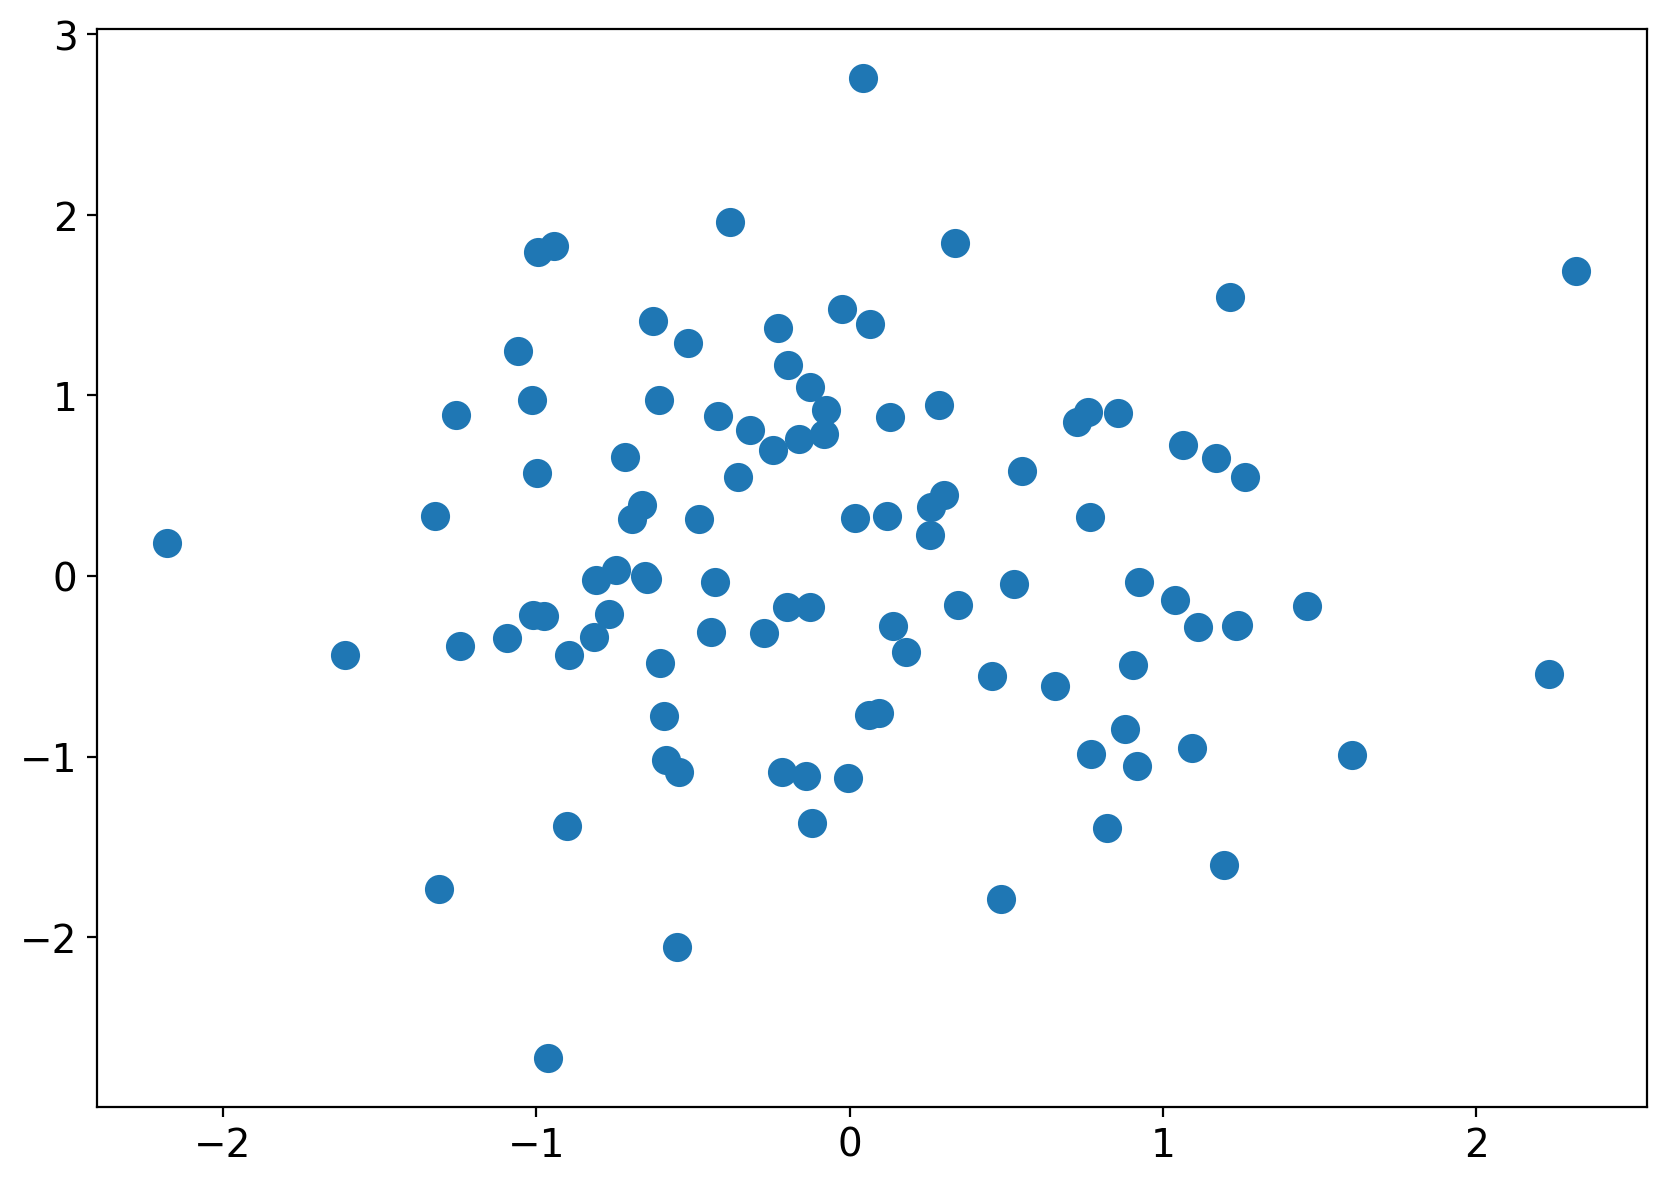

In [17]:
# np.random.seed(1)

n, m = 2, 100
A = np.random.randn(m, n)

plt.figure(figsize=(10, 7))
plt.scatter(A[:, 0], A[:, 1], s=90)

In [18]:
X = cp.Variable((n, n))
b = cp.Variable(n)

obj = cp.Minimize(-cp.log_det(X))

constraints = [cp.norm(X @ a + b) <= 1 for a in A]

problem = cp.Problem(obj, constraints)
_ = problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Apr 17 11:20:28 AM: Your problem has 6 variables, 100 constraints, and 0 parameters.
(CVXPY) Apr 17 11:20:29 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 11:20:29 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 11:20:29 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 11:20:29 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 11:20:29 AM: Compiling problem (target solver=SCS).
(CVX

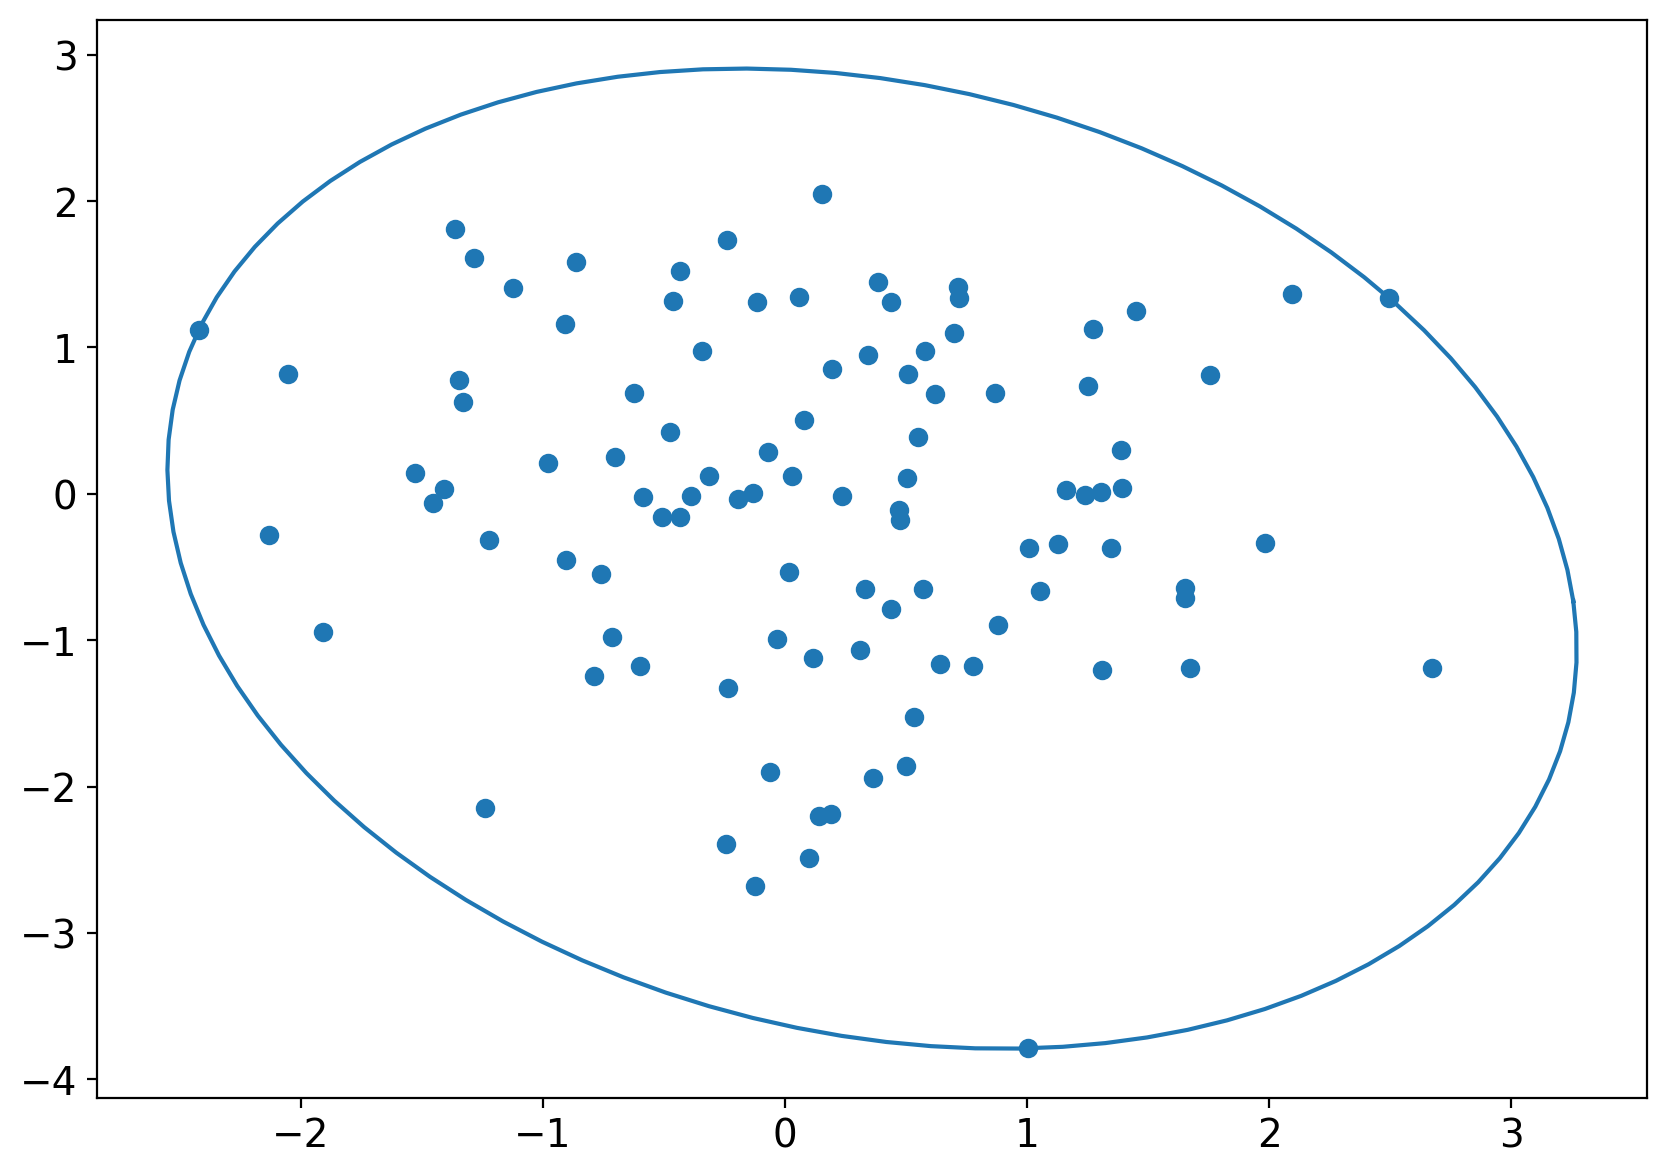

In [17]:
L = np.linalg.inv(X.value)
plt.figure(figsize=(10, 7))
plt.scatter(A[:, 0], A[:, 1])
phi = np.linspace(0, 2 * np.pi, num=100)
xy = np.vstack((np.cos(phi), np.sin(phi))) - b.value.reshape(-1, 1)
ellips = L.dot(xy)
plt.plot(ellips[0, :], ellips[1, :])

### Задача встречи двух тел
Два тела двигаются с трением на плоскости. Даны их начальные координаты и скорости

Мы можем управлять их ускорениями. Нужно найти такие ускорения (управления) для обоих тел, чтобы их конечные состояния были одинаковыми и было потрачено суммарно минимум энергии



- Дискретизуем уравнения динамики линейной системы (для одного тела)

$$
x_{t+1} = Ax_t + Bu_t
$$
$$
m \frac{v_{t+1} - v_t}{\tau} \approx -\eta v_t + u_t \quad \frac{p_{t+1} - p_t}{\tau} \approx v_{t},
$$
    Здесь $x_t$ - общий вектор состояния, состоящий из пространственных координат $p_t = (p^x_t, p^y_t)$ и вектора скорости $v_t = (v^x_t, v^y_t) $
    $u_t$ - вектор ускорения, $\eta$ - коэффициент трения, $\tau$ - квант времени
 
- Приближённо имеем следующую систему

$$
v_{t+1} = \left(1 - \frac{\tau}{m}\eta \right)v_t + \frac{\tau}{m}u_t \quad p_{t+1} = p_t + \tau v_t
$$

- Запись в стандартной форме

$$
x_{t} = \begin{bmatrix} p^x_t \\ p^y_t \\ v^x_t \\ v^y_t \end{bmatrix} \quad A = \begin{bmatrix} 1 & 0 & \tau & 0 \\ 0 & 1 & 0 & \tau \\ 0 & 0 & 1 - \frac{\tau}{m}\eta & 0\\ 0 & 0 & 0 & 1 - \frac{\tau}{m}\eta  \end{bmatrix} \quad B = \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \frac{\tau}{m} & 0 \\ 0 & \frac{\tau}{m} \end{bmatrix}
$$


- Будем считать, что затраты энергии пропорциональны сумме квадратов ускорений
- Тогда задача встречи двух тел формулируется как
$$
\begin{align*}
& \min_{\substack{u, w \in \R^{2\times T}\\x, z \in \R^{2\times (T+1)}}} \sum_{i=1}^T \|u_i\|_2^2 + \|w_i\|_2^2 \\
\text{s.t. } & x_{t+1} = Ax_t + Bu_t, \; t = 1,\ldots,T\\
& z_{t+1} = Cz_t + Dw_t, \; t = 1,\ldots,T\\
& x_T = z_T
\end{align*}
$$

In [18]:
# Задаём параметры системы
m1 = 1
eta1 = 0.1
m2 = 1
eta2 = 1
tau = 0.01
T = 100

# Собираем матрицы уравнений динамики
A = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta1 * tau / m1, 0], 
              [0, 0, 0, 1 - eta1 * tau / m1]])
B = np.array([[0, 0],
             [0, 0],
             [tau / m1, 0],
             [0, tau / m1]])

C = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta2 * tau / m2, 0], 
              [0, 0, 0, 1 - eta2 * tau / m2]])
D = np.array([[0, 0],
             [0, 0],
             [tau / m2, 0],
             [0, tau / m2]])

In [19]:
# Задаём начальные условия
x0 = np.array([0, 0, 10, 3])
z0 = np.array([10, 0, 10, -1])

In [20]:
x, z = cp.Variable((4, T + 1)), cp.Variable((4, T + 1))
u, w = cp.Variable((2, T)), cp.Variable((2, T))

cost = cp.sum_squares(u) + cp.sum_squares(w)
constraints = [x[:, 1:] == A @ x[:, :-1] + B @ u, z[:, 1:] == C @ z[:, :-1] + D @ w]  # Уравнения динамики
constraints += [x[:, T] == z[:, T], x[:, 0] == x0, z[:, 0] == z0]  # Начальные условия

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=0)

60727.0929563204

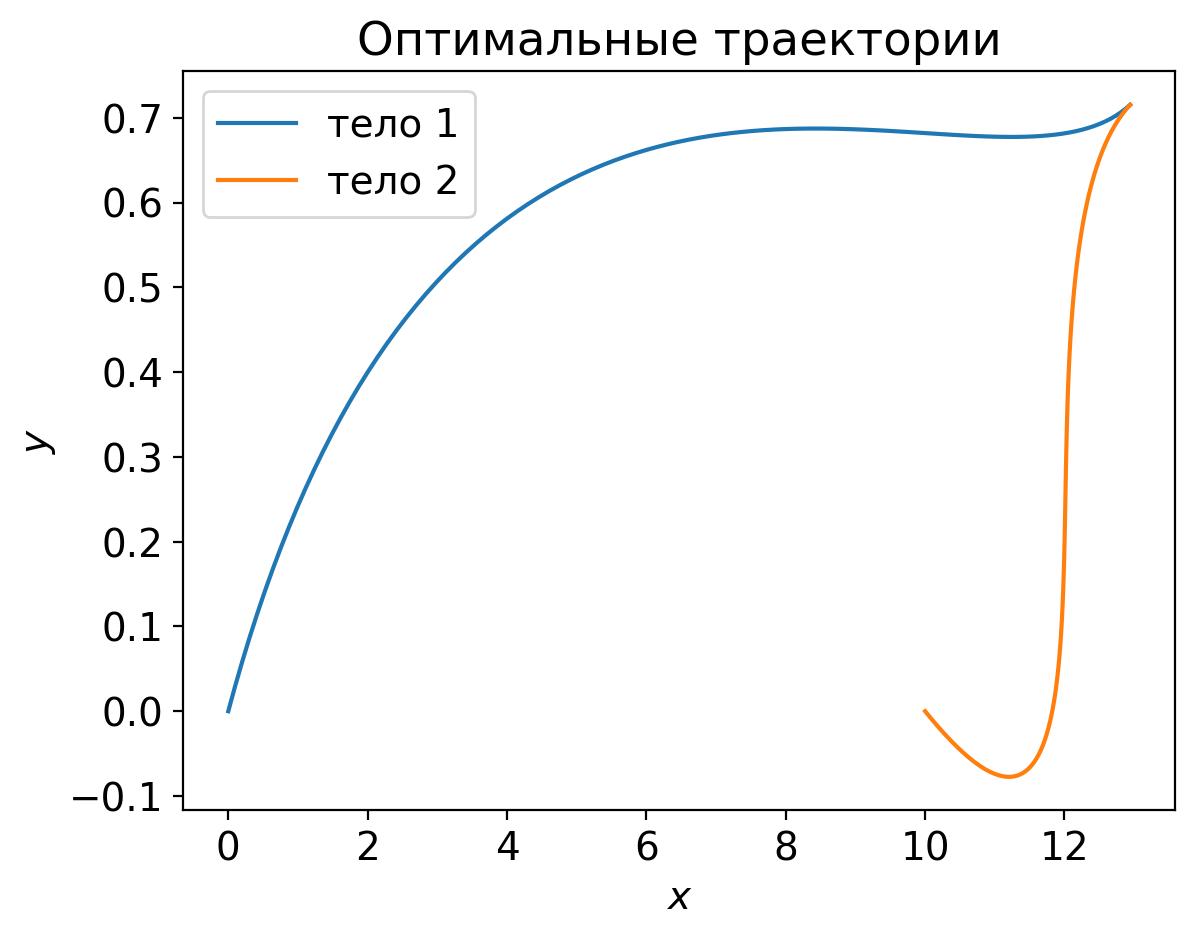

In [21]:
plt.plot(x.value[0, :], x.value[1, :], label="тело 1")
plt.plot(z.value[0, :], z.value[1, :], label="тело 2")
plt.title("Оптимальные траектории")
plt.legend()
_ = plt.xlabel(r"$x$"), plt.ylabel(r"$y$")

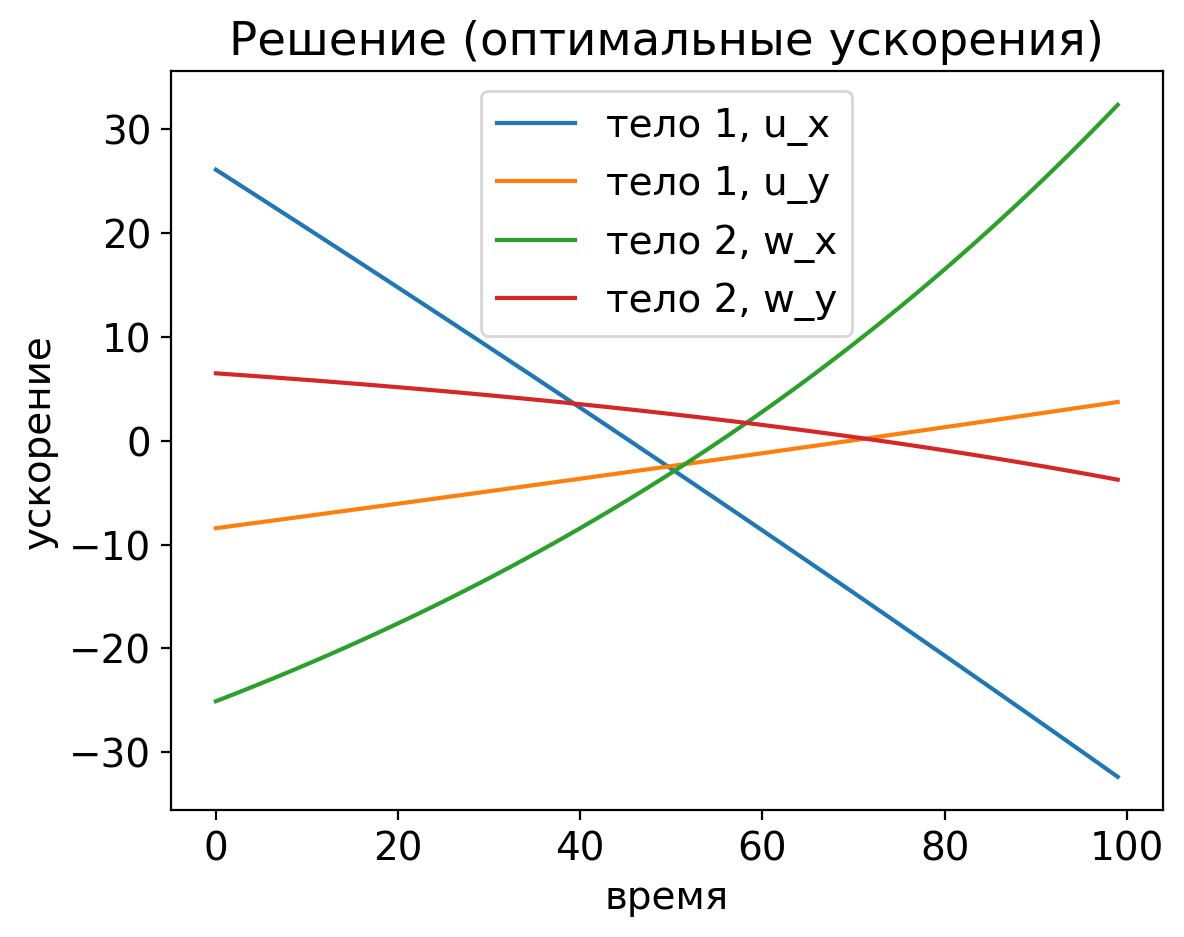

In [22]:
plt.title("Решение (оптимальные ускорения)")

plt.plot(u.value[0, :], label="тело 1, u_x")
plt.plot(u.value[1, :], label="тело 1, u_y")
plt.plot(w.value[0, :], label="тело 2, w_x")
plt.plot(w.value[1, :], label="тело 2, w_y")
plt.xlabel("время")
plt.ylabel("ускорение")

_ = plt.legend()


# SciPy.optimize
https://docs.scipy.org/doc/scipy/reference/optimize.html

- Функции (кроме функций `linprog` и `MILP`) принимают на вход черный ящик
- Нужно самому имплементить градиенты и гессианы
- Непосредственно к оптимизации относятся 
    - Функция `minimize_scalar` для одномерной минимизации / линпоиска
    - Функция `minimize` - для локальной/выпуклой многомерной минимизации
    - `linprog` и `MILP` - для LP и смешанного целочисленно-линейного программирования. Используется как солвер в CVXPY
    - Функции из группы глобальной оптимизации: `basinhopping`, `simulated_annealing` и др

## Локальная оптимизация
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Хайлайты из документации:

- Все алгоритмы в одной функции `minimize`, указываются через опциональный аргумент `method=`, или выбираются автоматически 

- Обязательно передать оракул нулевого порядка `fun=` и начальную точку `x0=`. Можно также передать функции вычисления градиента `jac=` и гессиана `hess=` или произведения гессиана на вектор `hessp=`. Если не передавать, могут быть примененены конечно-разностные схемы для их вычисления. 

- Можно указать "коробочные" ограничения на значения переменных через аргумент `bounds=`, а также линейные или нелинейные ограничения через аргумент `constraints=`.

- Знакомые нам алгоритмы: `CG`, `BFGS`, `Newton-CG` (неточный / truncated метод Ньютона, использующий CG для вычисления произведения обратного гессиана на вектор), `L-BFGS-B` - модификация `L-BFGS` для "коробочных" ограничений

- Разные алгоритмы работают с разными оракулами и различаются по способности обрабатывать ограничения. Если не указывать алгоритм через аргумент `method=`, SciPy будет использовать `BFGS`, `L-BFGS-B` или `SLSQP` в зависимости от наличия ограничений


### Пример: функция Розенброка

[wiki](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A0%D0%BE%D0%B7%D0%B5%D0%BD%D0%B1%D1%80%D0%BE%D0%BA%D0%B0)

В двумерном случае выглядит так (на википедии более контрастный график)

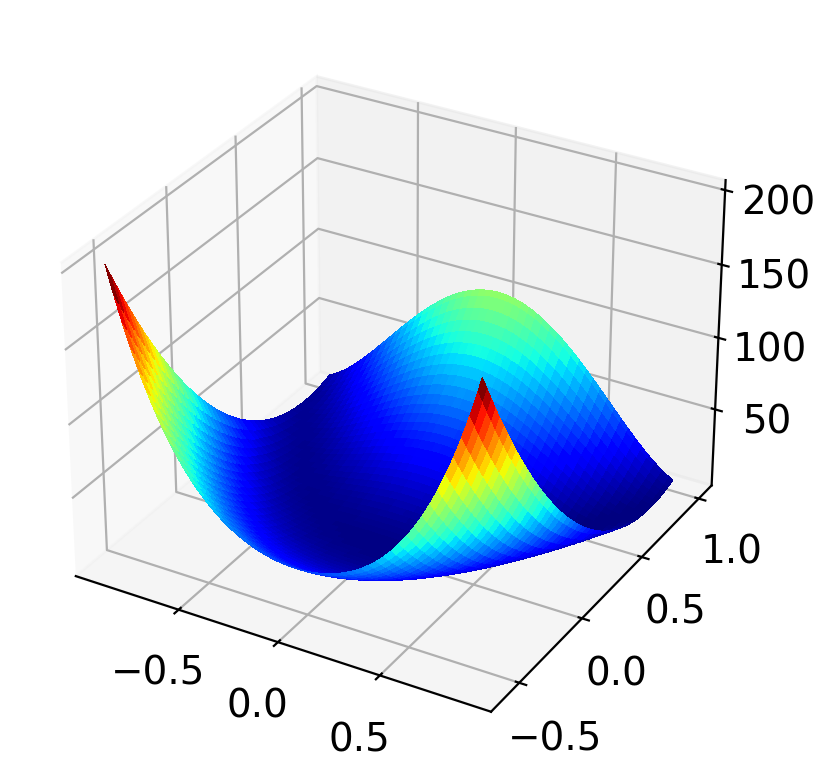

In [19]:
from scipy.optimize import minimize, rosen, rosen_der
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x = np.linspace(-0.9, 0.9, 100)
y = np.linspace(-0.6, 1, 100)
X, Y = np.meshgrid(x, y)
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X, Y, rosen([X, Y]), cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

In [20]:
x0 = np.random.random(20)

# Метод нулевого порядка
%timeit minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)

# BFGS, градиент приближается конечными разностями
%timeit minimize(rosen, x0, method='BFGS', options={'gtol': 1e-6})

# BFGS, точный градиент 
%timeit minimize(rosen, x0, method='BFGS', jac=rosen_der, options={'gtol': 1e-6})


287 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
198 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.7 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Глобальная оптимизация. TSP

Применим SciPy к задаче коммивояжера. Найдём кратчайший цикл на полном графе на плоскости с евклидовым расстоянием между вершинами.

Методы глобальной оптимизации в SciPy предназначены для минимизации функций на $\R^n$, поэтому нужен способ конвертации вектора из $\R^n$ в цикл на графе. Один из вариантов - определить порядок прохождения вершин равным порядку расположения компонент вектора после его сортировки, то есть сделать argsort 

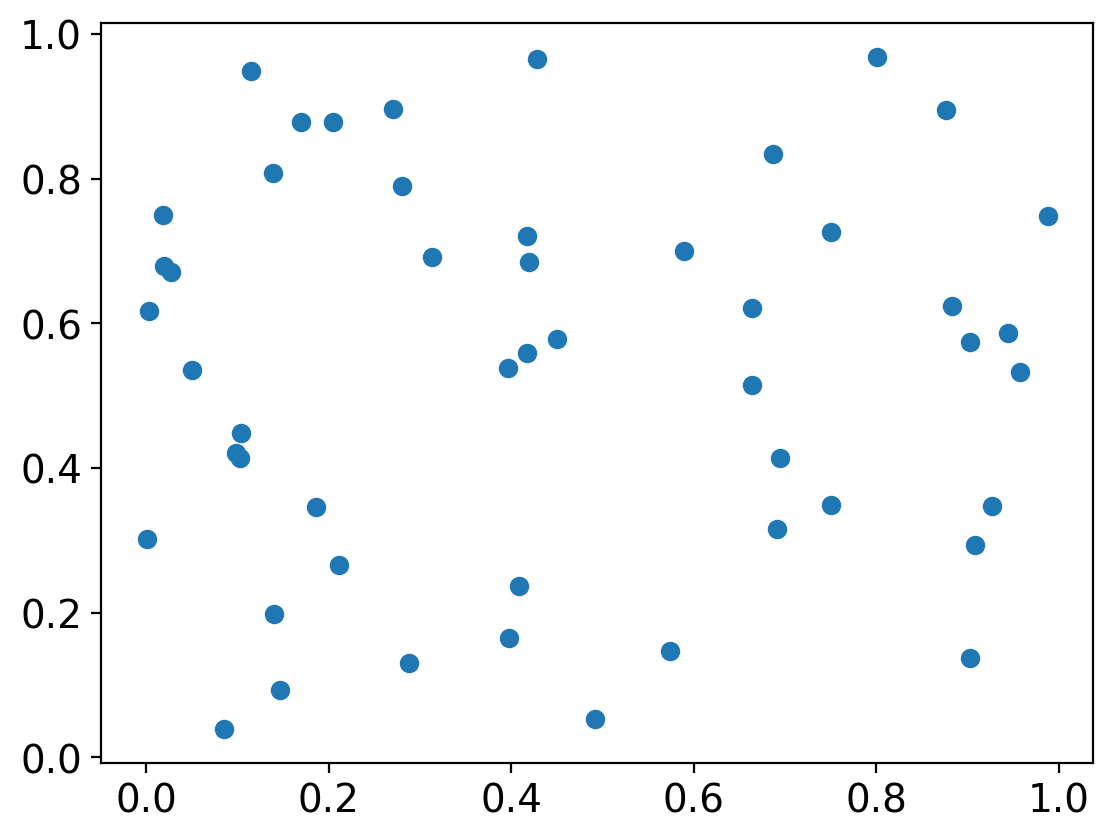

In [21]:
from scipy.optimize import dual_annealing, differential_evolution

np.random.seed(1)

# Создаём случайные точки
n = 50
points = np.random.random((n, 2))

plt.scatter(*points.T)

path len = 4.100231981215019


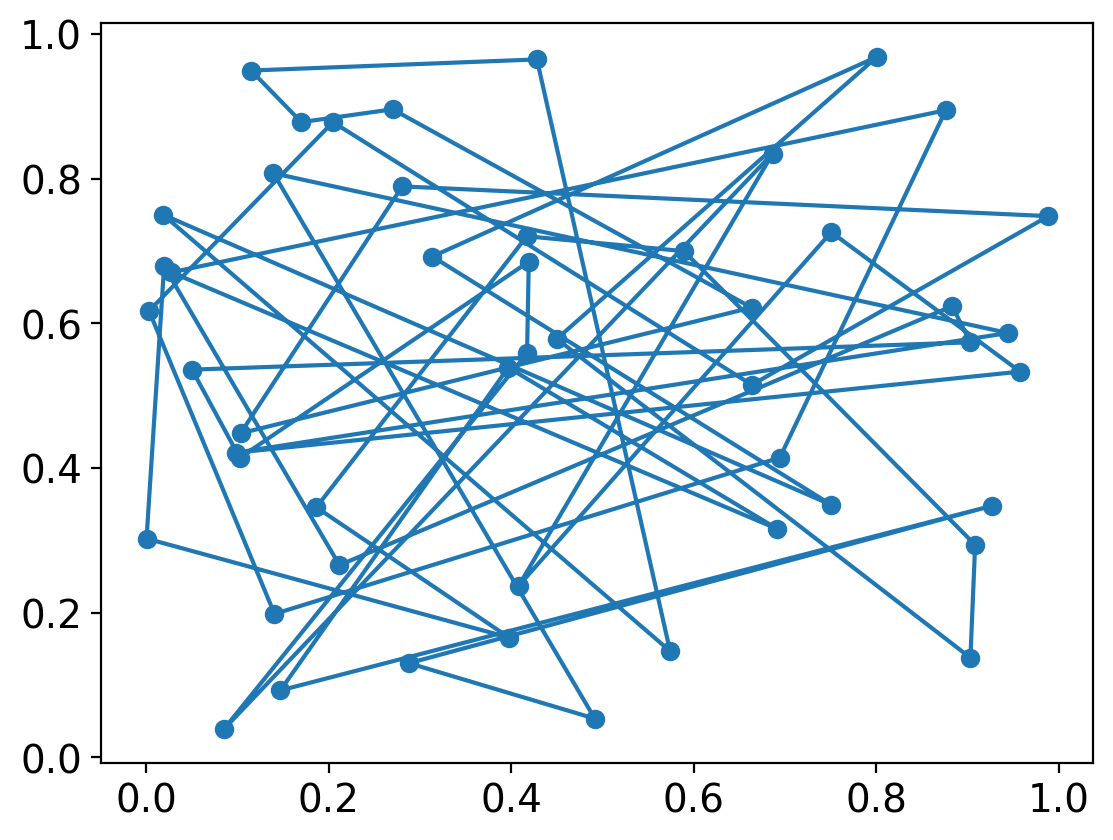

In [22]:
def path_len(path: np.ndarray):
    return (np.linalg.norm(points[np.roll(path, -1)] - points[path])).sum()

# Функция конвертации вектора из R^n в путь (список индексов вершин в порядке их прохождения)
def x_to_path(x: np.ndarray):
    return np.argsort(x)

# Целевая функция, определённая на R^n
def cost(x: np.ndarray):
    return path_len(x_to_path(x))

# Функция для рисования цикла, соответствующего вектору
def plot_x(x: np.ndarray):
    print(f"path len = {cost(x)}")
    path = x_to_path(x)
    plt.scatter(*points.T)
    plt.plot(*(points[np.hstack((path, path[0]))].T))
    plt.show()

# Начальное приближение
x0 = np.random.random(n)
plot_x(x0)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.85s/it]


CPU times: total: 48.9 s
Wall time: 2min 48s


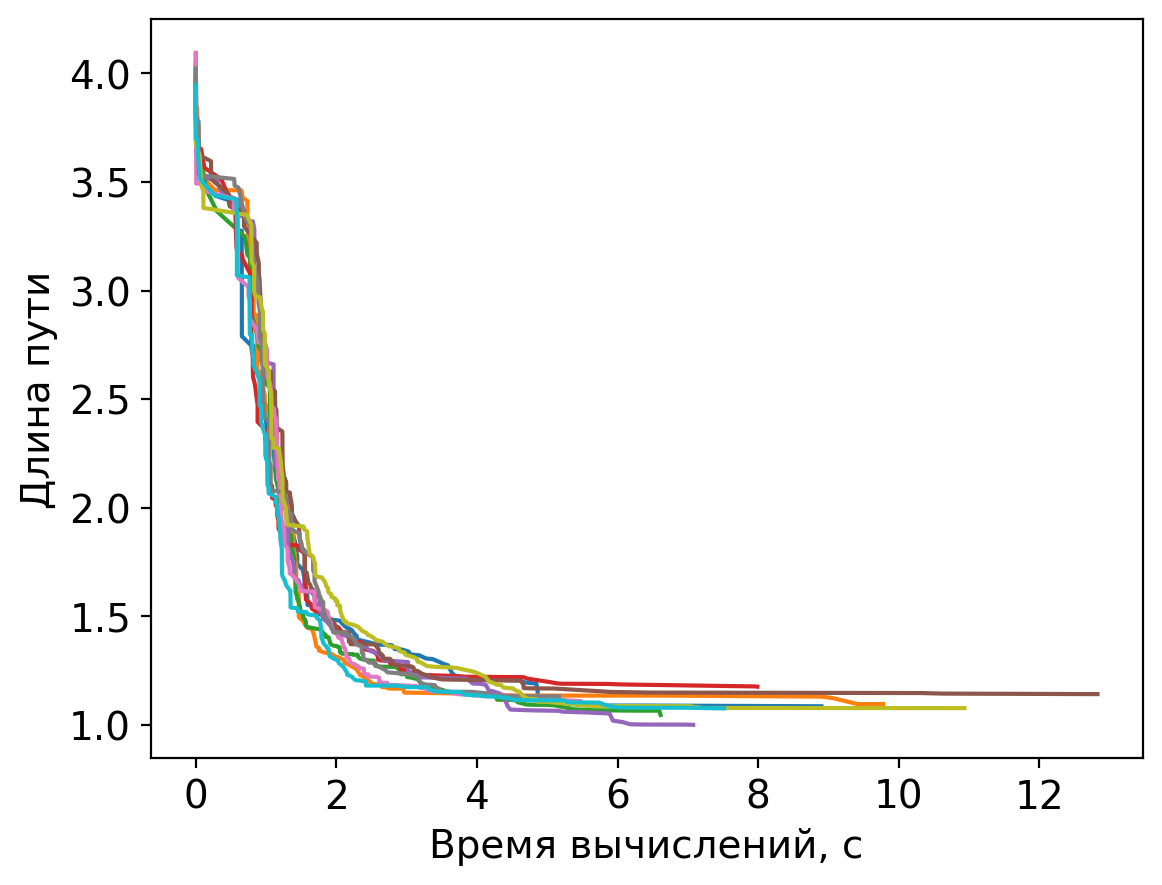

In [23]:
%%time
xlog = []
for trial in tqdm(range(10)): 
    flog = []
    t0 = time.time()
    res = dual_annealing(cost, bounds=[[0, 1]] * n, x0=x0, maxiter=1000,
                             callback=lambda x, fval, _: flog.append((time.time() - t0, fval)))
    
    plt.plot(*np.array(flog).T)
    xlog.append((res.x, res.fun))
    
plt.ylabel("Длина пути")
_ = plt.xlabel("Время вычислений, c")

In [30]:
print(res)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 1.0755345321976957
       x: [ 7.404e-01  3.416e-01 ...  1.865e-01  8.233e-01]
     nit: 1000
    nfev: 103979
    njev: 78
    nhev: 0


path len = 0.9996497260152417


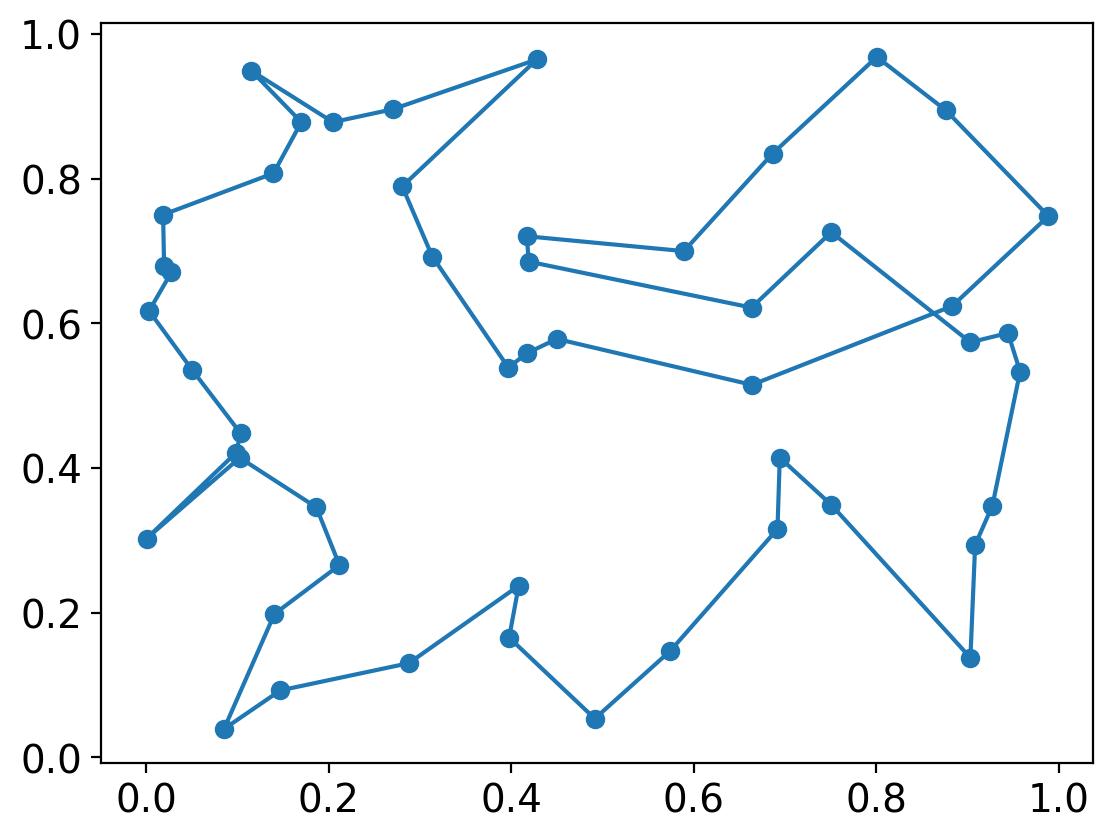

In [31]:
best_path_lens = [l[1] for l in xlog]
plot_x(xlog[np.argmin(best_path_lens)][0])

## linprog

Пример Klee, Minty (1972) [[1]](https://en.wikipedia.org/wiki/Klee–Minty_cube), на котором время работы симплекс-метода **экспоненциально** зависит от размерности задачи

В задаче
\begin{align*}
& \max_{x \in \mathbb{R}^n} 2^{n-1}x_1 + 2^{n-2}x_2 + \dots + 2x_{n-1} + x_n\\
\text{s.t. } & x_1 \leq 5\\
& 4x_1 + x_2 \leq 25\\
& 8x_1 + 4x_2 + x_3 \leq 125\\
& \ldots\\
& 2^n x_1 + 2^{n-1}x_2 + 2^{n-2}x_3 + \ldots + x_n \leq 5^n\\
& x \geq 0
\end{align*}
начиная с точки $x_0 = 0$ и следуя симплекс-методу, необходимо обойти $2^n - 1$ вершину.


In [32]:
def generate_KleeMinty_test_problem(n):
    c = np.array([2**i for i in range(n)])
    c = c[::-1]
    bounds = [(0, None) for i in range(n)]
    b = np.array([5**(i+1) for i in range(n)])
    a = np.array([1] + [2**(i+1) for i in range(1, n)])
    A = np.zeros((n, n))
    for i in range(n):
        A[i:, i] = a[:n-i]
    return -c, A, b, bounds

In [33]:
from scipy.optimize import linprog

# res = linprog(c, A, b, bounds=bounds, method="interior-point")

n_list = range(3, 14)
n_iters = np.zeros(len(n_list))
times = np.zeros(len(n_list))
for i, n in tqdm(enumerate(n_list)):
    c, A, b, bounds = generate_KleeMinty_test_problem(n)
    t0 = time.time()
    res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)}, method="revised simplex")
    n_iters[i] = res.nit
    times[i] = time.time() - t0
    

0it [00:00, ?it/s]/tmp/ipykernel_52813/3560857581.py:11: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)}, method="revised simplex")
11it [00:01,  6.78it/s]


Text(0, 0.5, 'Время вычислений, с')

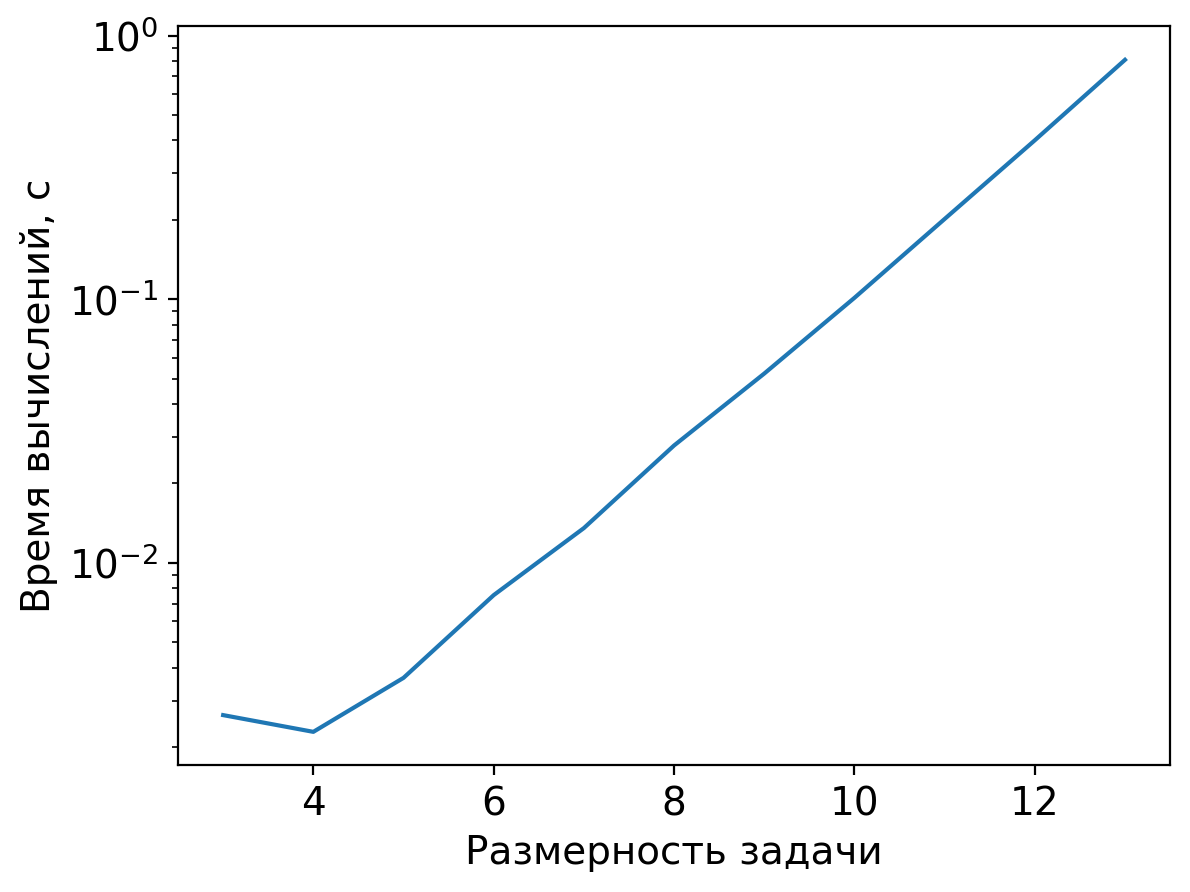

In [34]:
plt.plot(n_list, times)
plt.yscale("log")
plt.xlabel("Размерность задачи")
plt.ylabel("Время вычислений, с")